In [175]:
import torch.nn as nn
import torch
class CondVAE(nn.Module):
    def __init__(self,latent_dim=10, context_vector_size=6):
        super(CondVAE, self).__init__()
        
        self.latent_dim = latent_dim


        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim + 6, out_features=50),
            nn.ReLU(),
            nn.BatchNorm1d(50),  # Add BatchNorm1d layer
            nn.Linear(in_features=50, out_features=100),
            nn.ReLU(),
            nn.BatchNorm1d(100),  # Add BatchNorm1d layer
            nn.Linear(in_features=100, out_features=150),
            nn.ReLU(),
            nn.BatchNorm1d(150),  # Add BatchNorm1d layer
            nn.Linear(in_features=150, out_features=100),
            nn.ReLU(),
            nn.BatchNorm1d(100),  # Add BatchNorm1d layer
            nn.Linear(in_features=100, out_features=50),
            nn.ReLU(),
            nn.BatchNorm1d(50),  # Add BatchNorm1d layer
            nn.Linear(in_features=50, out_features=1),
        )

    
    def decode(self, z, context_vector):
        # Concatenate the sampling (latent distribution) + embedding -> samples conditioned on both the input data and the specified label
        zcomb = torch.concat((z, context_vector), 1)
        #print(zcomb.shape)
        
        return self.decoder(zcomb)     
    
    def sampling(self, mu, std):
        
        # create noise tensor of same size as std to add to the latent vector
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        
        # multiply eps with std to scale the random noise according to the learned distribution + add combined
        return eps.mul(std).add_(mu) # return z sample 

    def forward(self, context_vector):
        z = self.sampling(torch.zeros(size=(len(context_vector),latent_dim)).to(device), torch.ones(size=(len(context_vector),latent_dim)).to(device))
        #print(z.shape)

        return self.decode(z, context_vector)


In [176]:
import tqdm
import torch
import torch.nn as nn

def condvae_loss(pred, label):
    """
    Calculate the conditional Variational Autoencoder (cVAE) loss.

    This function computes the cVAE loss, which consists of two components:
    - Reconstruction loss: Measures the discrepancy between the reconstructed
      data and the original input.
    - KL divergence loss: Quantifies the difference between the learned latent
      distribution and the desired prior distribution (Gaussian).

    Args:
        recon_x (torch.Tensor): Reconstructed data from the VAE.
        x (torch.Tensor): Original input data.
        mu (torch.Tensor): Latent variable mean.
        logvar (torch.Tensor): Logarithm of latent variable variance.

    Returns:
        torch.Tensor: Computed cVAE loss.
    """
    
    # MSE loss element-wise and sums up the individual losses
    cde_loss = nn.MSELoss(reduction='mean')(pred, label)
    
    
    return cde_loss 

def VAE_trainEpoch(model, optimizer, train_loader, val_loader, dim_in=100):
    """
    Train a Variational Autoencoder (VAE) for one epoch.

    This function trains a VAE for one epoch using the provided data loader.
    It calculates the cVAE loss, performs backpropagation, and updates the model's parameters.

    Args:
        model (nn.Module): VAE model to be trained.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        train_loader (DataLoader): DataLoader containing training data.
        dim_in (int): Dimensionality of the input noise.

    Returns:
        float: Average loss for the epoch.
    """
    model = model.train()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    total_loss = 0
    total_loss_val = 0

    progress_bar = tqdm.tqdm(train_loader, desc="Train epoch Progress", leave=True)

    for context_vector, label in progress_bar:
        context_vector = context_vector.to(device)
        label = label.unsqueeze(1).cuda()
        optimizer.zero_grad()

        recon_batch = model(context_vector)
        loss = condvae_loss(recon_batch, label)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"Training Loss": total_loss / (progress_bar.n + 1)})
        
    for context_vector_validation, label_validation in loader_val:
        optimizer.zero_grad()
        context_vector_validation = context_vector_validation.to(device)
        label_validation = label_validation.unsqueeze(1).cuda()

        recon_batch_val = model(context_vector_validation)
        loss_val = condvae_loss(recon_batch_val, label_validation)
        
        total_loss_val+= loss_val.item()

    return total_loss / len(train_loader), total_loss_val / len(val_loader)

def VAE_train(model, optimizer, train_loader, val_loader,epochs, save_path=None):
    """
    Train a Variational Autoencoder (VAE) for multiple epochs.

    This function trains a VAE for the specified number of epochs using the provided data loader.
    It prints the epoch progress and the computed loss for each epoch.

    Args:
        model (nn.Module): VAE model to be trained.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        train_loader (DataLoader): DataLoader containing training data.
        epochs (int): Number of epochs for training.

    Returns:
        None
    """
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_loss, epoch_valloss = VAE_trainEpoch(model, optimizer, train_loader, val_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss Train: {epoch_loss:.4f}")
        print(f"Epoch {epoch + 1}/{epochs}, Loss Val: {epoch_valloss:.4f}")

        
    if save_path!=None:
        torch.save(model, save_path)



In [177]:
import numpy as np
import pandas as pd
from astropy.io import fits
import os
from astropy.table import Table
from scipy.spatial import KDTree

import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML 

In [178]:
import torch
from torch.utils.data import DataLoader, dataset, TensorDataset
from torch import nn, optim
from torch.optim import lr_scheduler

In [179]:
import sys
sys.path.append('../insight')
from archive import archive 
from insight_arch import Photoz_network
from insight import Insight_module
from utils import sigma68, nmad, plot_photoz_estimates
from scipy import stats

In [180]:
from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"
parent_dir = '/data/astro/scratch/lcabayol/Euclid/NNphotozs/Euclid_EXT_MER_PHZ_DC2_v1.5'

In [181]:
photoz_archive = archive(path = parent_dir, Qz_cut=1)
f, ferr, specz, specqz = photoz_archive.get_training_data()

In [182]:
dset = TensorDataset(torch.Tensor(f),torch.Tensor(specz))


In [183]:
from torch.utils.data import random_split
dset_train, dset_val = random_split(dset, [int(0.9*len(dset)+1), int(0.1*len(dset))])

In [184]:
loader = DataLoader(dset_train, batch_size=100, shuffle=True)
loader_val = DataLoader(dset_val, batch_size=100, shuffle=False)

In [185]:
latent_dim=1
context_vector_dim=6
epochs=100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [186]:
vae = CondVAE(latent_dim=latent_dim, context_vector_size=6).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-4)


In [187]:
VAE_train(vae, optimizer, loader, loader_val, epochs, save_path=None)

Epoch 1/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 108.29it/s, Training Loss=0.398]


Epoch 1/100, Loss Train: 0.3795
Epoch 1/100, Loss Val: 0.3233
Epoch 2/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.67it/s, Training Loss=0.288]


Epoch 2/100, Loss Train: 0.2611
Epoch 2/100, Loss Val: 0.3001
Epoch 3/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.80it/s, Training Loss=0.265]


Epoch 3/100, Loss Train: 0.2452
Epoch 3/100, Loss Val: 0.2695
Epoch 4/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.80it/s, Training Loss=0.256]


Epoch 4/100, Loss Train: 0.2303
Epoch 4/100, Loss Val: 0.2764
Epoch 5/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 111.45it/s, Training Loss=0.244]


Epoch 5/100, Loss Train: 0.2234
Epoch 5/100, Loss Val: 0.2551
Epoch 6/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.87it/s, Training Loss=0.231]


Epoch 6/100, Loss Train: 0.2100
Epoch 6/100, Loss Val: 0.2387
Epoch 7/100


Train epoch Progress: 100%|██████████| 108/108 [00:01<00:00, 107.72it/s, Training Loss=0.212]


Epoch 7/100, Loss Train: 0.2117
Epoch 7/100, Loss Val: 0.2331
Epoch 8/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 108.85it/s, Training Loss=0.209]


Epoch 8/100, Loss Train: 0.2051
Epoch 8/100, Loss Val: 0.2296
Epoch 9/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.82it/s, Training Loss=0.217]


Epoch 9/100, Loss Train: 0.1970
Epoch 9/100, Loss Val: 0.2230
Epoch 10/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.36it/s, Training Loss=0.195]


Epoch 10/100, Loss Train: 0.1936
Epoch 10/100, Loss Val: 0.2394
Epoch 11/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.43it/s, Training Loss=0.194]


Epoch 11/100, Loss Train: 0.1903
Epoch 11/100, Loss Val: 0.2240
Epoch 12/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.83it/s, Training Loss=0.191]


Epoch 12/100, Loss Train: 0.1889
Epoch 12/100, Loss Val: 0.2232
Epoch 13/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 112.16it/s, Training Loss=0.204]


Epoch 13/100, Loss Train: 0.1874
Epoch 13/100, Loss Val: 0.2163
Epoch 14/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.30it/s, Training Loss=0.2] 


Epoch 14/100, Loss Train: 0.1831
Epoch 14/100, Loss Val: 0.2149
Epoch 15/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.58it/s, Training Loss=0.201]


Epoch 15/100, Loss Train: 0.1861
Epoch 15/100, Loss Val: 0.2523
Epoch 16/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.23it/s, Training Loss=0.185]


Epoch 16/100, Loss Train: 0.1816
Epoch 16/100, Loss Val: 0.2232
Epoch 17/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.59it/s, Training Loss=0.195]


Epoch 17/100, Loss Train: 0.1784
Epoch 17/100, Loss Val: 0.2079
Epoch 18/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.85it/s, Training Loss=0.198]


Epoch 18/100, Loss Train: 0.1831
Epoch 18/100, Loss Val: 0.2148
Epoch 19/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 111.15it/s, Training Loss=0.192]


Epoch 19/100, Loss Train: 0.1738
Epoch 19/100, Loss Val: 0.2112
Epoch 20/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.93it/s, Training Loss=0.193]


Epoch 20/100, Loss Train: 0.1749
Epoch 20/100, Loss Val: 0.2141
Epoch 21/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 108.67it/s, Training Loss=0.171]


Epoch 21/100, Loss Train: 0.1714
Epoch 21/100, Loss Val: 0.2108
Epoch 22/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.55it/s, Training Loss=0.189]


Epoch 22/100, Loss Train: 0.1718
Epoch 22/100, Loss Val: 0.2076
Epoch 23/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 111.42it/s, Training Loss=0.182]


Epoch 23/100, Loss Train: 0.1698
Epoch 23/100, Loss Val: 0.2030
Epoch 24/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.38it/s, Training Loss=0.182]


Epoch 24/100, Loss Train: 0.1651
Epoch 24/100, Loss Val: 0.2000
Epoch 25/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.63it/s, Training Loss=0.166]


Epoch 25/100, Loss Train: 0.1660
Epoch 25/100, Loss Val: 0.1994
Epoch 26/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.36it/s, Training Loss=0.164]


Epoch 26/100, Loss Train: 0.1624
Epoch 26/100, Loss Val: 0.1912
Epoch 27/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 111.92it/s, Training Loss=0.172]


Epoch 27/100, Loss Train: 0.1580
Epoch 27/100, Loss Val: 0.1975
Epoch 28/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.56it/s, Training Loss=0.171]


Epoch 28/100, Loss Train: 0.1586
Epoch 28/100, Loss Val: 0.2098
Epoch 29/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 111.95it/s, Training Loss=0.181]


Epoch 29/100, Loss Train: 0.1656
Epoch 29/100, Loss Val: 0.1941
Epoch 30/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.61it/s, Training Loss=0.153]


Epoch 30/100, Loss Train: 0.1529
Epoch 30/100, Loss Val: 0.1856
Epoch 31/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.90it/s, Training Loss=0.167]


Epoch 31/100, Loss Train: 0.1513
Epoch 31/100, Loss Val: 0.1861
Epoch 32/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.44it/s, Training Loss=0.156]


Epoch 32/100, Loss Train: 0.1562
Epoch 32/100, Loss Val: 0.1877
Epoch 33/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.27it/s, Training Loss=0.153]


Epoch 33/100, Loss Train: 0.1526
Epoch 33/100, Loss Val: 0.1884
Epoch 34/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.51it/s, Training Loss=0.153]


Epoch 34/100, Loss Train: 0.1530
Epoch 34/100, Loss Val: 0.1977
Epoch 35/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 108.86it/s, Training Loss=0.156]


Epoch 35/100, Loss Train: 0.1560
Epoch 35/100, Loss Val: 0.1867
Epoch 36/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 108.75it/s, Training Loss=0.152]


Epoch 36/100, Loss Train: 0.1451
Epoch 36/100, Loss Val: 0.1865
Epoch 37/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.47it/s, Training Loss=0.16]


Epoch 37/100, Loss Train: 0.1471
Epoch 37/100, Loss Val: 0.1956
Epoch 38/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.78it/s, Training Loss=0.16]


Epoch 38/100, Loss Train: 0.1469
Epoch 38/100, Loss Val: 0.2036
Epoch 39/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 111.59it/s, Training Loss=0.167]


Epoch 39/100, Loss Train: 0.1551
Epoch 39/100, Loss Val: 0.1791
Epoch 40/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.67it/s, Training Loss=0.165]


Epoch 40/100, Loss Train: 0.1496
Epoch 40/100, Loss Val: 0.2094
Epoch 41/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.87it/s, Training Loss=0.143]


Epoch 41/100, Loss Train: 0.1432
Epoch 41/100, Loss Val: 0.2049
Epoch 42/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.74it/s, Training Loss=0.15] 


Epoch 42/100, Loss Train: 0.1503
Epoch 42/100, Loss Val: 0.1915
Epoch 43/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.44it/s, Training Loss=0.148]


Epoch 43/100, Loss Train: 0.1468
Epoch 43/100, Loss Val: 0.2011
Epoch 44/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 108.92it/s, Training Loss=0.143]


Epoch 44/100, Loss Train: 0.1430
Epoch 44/100, Loss Val: 0.1923
Epoch 45/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.69it/s, Training Loss=0.164]


Epoch 45/100, Loss Train: 0.1489
Epoch 45/100, Loss Val: 0.1806
Epoch 46/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.35it/s, Training Loss=0.151]


Epoch 46/100, Loss Train: 0.1493
Epoch 46/100, Loss Val: 0.1975
Epoch 47/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.05it/s, Training Loss=0.141]


Epoch 47/100, Loss Train: 0.1408
Epoch 47/100, Loss Val: 0.1966
Epoch 48/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.30it/s, Training Loss=0.14] 


Epoch 48/100, Loss Train: 0.1385
Epoch 48/100, Loss Val: 0.2006
Epoch 49/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.61it/s, Training Loss=0.156]


Epoch 49/100, Loss Train: 0.1417
Epoch 49/100, Loss Val: 0.1841
Epoch 50/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.82it/s, Training Loss=0.154]


Epoch 50/100, Loss Train: 0.1393
Epoch 50/100, Loss Val: 0.1758
Epoch 51/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 111.40it/s, Training Loss=0.152]


Epoch 51/100, Loss Train: 0.1406
Epoch 51/100, Loss Val: 0.2048
Epoch 52/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 111.47it/s, Training Loss=0.149]


Epoch 52/100, Loss Train: 0.1348
Epoch 52/100, Loss Val: 0.1996
Epoch 53/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.85it/s, Training Loss=0.145]


Epoch 53/100, Loss Train: 0.1440
Epoch 53/100, Loss Val: 0.1875
Epoch 54/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.56it/s, Training Loss=0.142]


Epoch 54/100, Loss Train: 0.1412
Epoch 54/100, Loss Val: 0.1831
Epoch 55/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 114.75it/s, Training Loss=0.143]


Epoch 55/100, Loss Train: 0.1354
Epoch 55/100, Loss Val: 0.1808
Epoch 56/100


Train epoch Progress: 100%|██████████| 108/108 [00:01<00:00, 107.49it/s, Training Loss=0.149]


Epoch 56/100, Loss Train: 0.1382
Epoch 56/100, Loss Val: 0.1871
Epoch 57/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.51it/s, Training Loss=0.147]


Epoch 57/100, Loss Train: 0.1345
Epoch 57/100, Loss Val: 0.1875
Epoch 58/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 111.09it/s, Training Loss=0.142]


Epoch 58/100, Loss Train: 0.1311
Epoch 58/100, Loss Val: 0.1846
Epoch 59/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.32it/s, Training Loss=0.139]


Epoch 59/100, Loss Train: 0.1389
Epoch 59/100, Loss Val: 0.1799
Epoch 60/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.61it/s, Training Loss=0.128]


Epoch 60/100, Loss Train: 0.1284
Epoch 60/100, Loss Val: 0.1775
Epoch 61/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.67it/s, Training Loss=0.143]


Epoch 61/100, Loss Train: 0.1300
Epoch 61/100, Loss Val: 0.1720
Epoch 62/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.09it/s, Training Loss=0.153]


Epoch 62/100, Loss Train: 0.1370
Epoch 62/100, Loss Val: 0.1770
Epoch 63/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 111.03it/s, Training Loss=0.142]


Epoch 63/100, Loss Train: 0.1298
Epoch 63/100, Loss Val: 0.1834
Epoch 64/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.27it/s, Training Loss=0.13] 


Epoch 64/100, Loss Train: 0.1285
Epoch 64/100, Loss Val: 0.1854
Epoch 65/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.63it/s, Training Loss=0.144]


Epoch 65/100, Loss Train: 0.1304
Epoch 65/100, Loss Val: 0.1884
Epoch 66/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.47it/s, Training Loss=0.142]


Epoch 66/100, Loss Train: 0.1311
Epoch 66/100, Loss Val: 0.1799
Epoch 67/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.58it/s, Training Loss=0.129]


Epoch 67/100, Loss Train: 0.1268
Epoch 67/100, Loss Val: 0.1878
Epoch 68/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.29it/s, Training Loss=0.144]


Epoch 68/100, Loss Train: 0.1307
Epoch 68/100, Loss Val: 0.1912
Epoch 69/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.00it/s, Training Loss=0.135]


Epoch 69/100, Loss Train: 0.1320
Epoch 69/100, Loss Val: 0.1881
Epoch 70/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.43it/s, Training Loss=0.129]


Epoch 70/100, Loss Train: 0.1290
Epoch 70/100, Loss Val: 0.1734
Epoch 71/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.95it/s, Training Loss=0.129]


Epoch 71/100, Loss Train: 0.1292
Epoch 71/100, Loss Val: 0.1997
Epoch 72/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 112.36it/s, Training Loss=0.131]


Epoch 72/100, Loss Train: 0.1239
Epoch 72/100, Loss Val: 0.1901
Epoch 73/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.86it/s, Training Loss=0.146]


Epoch 73/100, Loss Train: 0.1325
Epoch 73/100, Loss Val: 0.1945
Epoch 74/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 111.15it/s, Training Loss=0.143]


Epoch 74/100, Loss Train: 0.1313
Epoch 74/100, Loss Val: 0.1839
Epoch 75/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.50it/s, Training Loss=0.131]


Epoch 75/100, Loss Train: 0.1204
Epoch 75/100, Loss Val: 0.1881
Epoch 76/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.22it/s, Training Loss=0.14]


Epoch 76/100, Loss Train: 0.1280
Epoch 76/100, Loss Val: 0.1766
Epoch 77/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.70it/s, Training Loss=0.123]


Epoch 77/100, Loss Train: 0.1225
Epoch 77/100, Loss Val: 0.1800
Epoch 78/100


Train epoch Progress: 100%|██████████| 108/108 [00:01<00:00, 107.92it/s, Training Loss=0.126]


Epoch 78/100, Loss Train: 0.1224
Epoch 78/100, Loss Val: 0.1783
Epoch 79/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.75it/s, Training Loss=0.14]


Epoch 79/100, Loss Train: 0.1269
Epoch 79/100, Loss Val: 0.1827
Epoch 80/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.85it/s, Training Loss=0.128]


Epoch 80/100, Loss Train: 0.1271
Epoch 80/100, Loss Val: 0.1747
Epoch 81/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 108.30it/s, Training Loss=0.124]


Epoch 81/100, Loss Train: 0.1236
Epoch 81/100, Loss Val: 0.1961
Epoch 82/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.94it/s, Training Loss=0.133]


Epoch 82/100, Loss Train: 0.1220
Epoch 82/100, Loss Val: 0.1829
Epoch 83/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.31it/s, Training Loss=0.128]


Epoch 83/100, Loss Train: 0.1252
Epoch 83/100, Loss Val: 0.1801
Epoch 84/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.85it/s, Training Loss=0.123]


Epoch 84/100, Loss Train: 0.1226
Epoch 84/100, Loss Val: 0.1784
Epoch 85/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.45it/s, Training Loss=0.121]


Epoch 85/100, Loss Train: 0.1195
Epoch 85/100, Loss Val: 0.1822
Epoch 86/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.70it/s, Training Loss=0.134]


Epoch 86/100, Loss Train: 0.1229
Epoch 86/100, Loss Val: 0.1825
Epoch 87/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 115.77it/s, Training Loss=0.127]


Epoch 87/100, Loss Train: 0.1172
Epoch 87/100, Loss Val: 0.1881
Epoch 88/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 114.24it/s, Training Loss=0.122]


Epoch 88/100, Loss Train: 0.1179
Epoch 88/100, Loss Val: 0.1860
Epoch 89/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.22it/s, Training Loss=0.119]


Epoch 89/100, Loss Train: 0.1170
Epoch 89/100, Loss Val: 0.1829
Epoch 90/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 108.72it/s, Training Loss=0.12] 


Epoch 90/100, Loss Train: 0.1193
Epoch 90/100, Loss Val: 0.1891
Epoch 91/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.20it/s, Training Loss=0.124]


Epoch 91/100, Loss Train: 0.1127
Epoch 91/100, Loss Val: 0.1931
Epoch 92/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.06it/s, Training Loss=0.116]


Epoch 92/100, Loss Train: 0.1164
Epoch 92/100, Loss Val: 0.2019
Epoch 93/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.03it/s, Training Loss=0.121]


Epoch 93/100, Loss Train: 0.1183
Epoch 93/100, Loss Val: 0.1899
Epoch 94/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 108.92it/s, Training Loss=0.122]


Epoch 94/100, Loss Train: 0.1224
Epoch 94/100, Loss Val: 0.1807
Epoch 95/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.17it/s, Training Loss=0.115]


Epoch 95/100, Loss Train: 0.1131
Epoch 95/100, Loss Val: 0.1818
Epoch 96/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.09it/s, Training Loss=0.126]


Epoch 96/100, Loss Train: 0.1141
Epoch 96/100, Loss Val: 0.1824
Epoch 97/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 110.62it/s, Training Loss=0.127]


Epoch 97/100, Loss Train: 0.1149
Epoch 97/100, Loss Val: 0.1822
Epoch 98/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 111.70it/s, Training Loss=0.124]


Epoch 98/100, Loss Train: 0.1149
Epoch 98/100, Loss Val: 0.1686
Epoch 99/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 111.09it/s, Training Loss=0.126]


Epoch 99/100, Loss Train: 0.1169
Epoch 99/100, Loss Val: 0.1820
Epoch 100/100


Train epoch Progress: 100%|██████████| 108/108 [00:00<00:00, 109.30it/s, Training Loss=0.116]


Epoch 100/100, Loss Train: 0.1163
Epoch 100/100, Loss Val: 0.1814


In [197]:
f_test, ferr_test, specz_test = photoz_archive.get_testing_data()
dset_test = TensorDataset(torch.Tensor(f_test),torch.Tensor(specz_test))
loader_test = DataLoader(dset_test, batch_size=100, shuffle=False)

In [212]:
py_z_list.shape

(100, 100, 1)

In [211]:
Nsamp=100
samp_lim=1000
vae = vae.eval()
py_z_list = []
pz_y = np.zeros(shape=(samp_lim,samp_lim))
ztrue = []
for ii, (context_vector_validation, label_validation) in enumerate(loader_test):
            
    if ii>(samp_lim-1): 
        break
        
    context_vector_validation = context_vector_validation.to(device)
        
    for jj in range(Nsamp):
        z = vae.sampling(torch.zeros(size=(len(context_vector_validation),latent_dim)).to(device), torch.ones(size=(len(context_vector_validation),latent_dim)).to(device))
        py_z_list.append(vae.decode(z.to(device),context_vector_validation).detach().cpu().numpy())
        

ValueError: could not broadcast input array from shape (100,100,1) into shape (1000,)

In [208]:
py_z = np.array(py_z)

/tmp/ipykernel_65/4229676729.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  py_z = np.array(py_z)


In [210]:
py_z.reshape(samp_lim,Nsamp)

ValueError: cannot reshape array of size 11600 into shape (1000,100)

In [207]:
len(py_z[0])

100

In [205]:
np.vstack(py_z).shape

(1151400, 1)

In [201]:
m=305

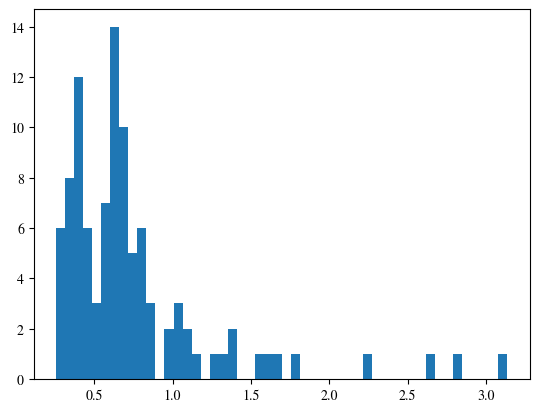

In [202]:
plt.hist(py_z[m], bins =50)
plt.show()

In [192]:
ztrue[m]

array([0.22139999])

In [193]:
zmean = py_z.mean(1)

In [194]:
rerrz = (zmean-ztrue[:,0])/(1+ztrue[:,0])

In [195]:
rerrz.mean()

0.04469466897810881

In [173]:
from utils import sigma68, nmad, plot_photoz_estimates


Text(0, 0.5, '$z$')

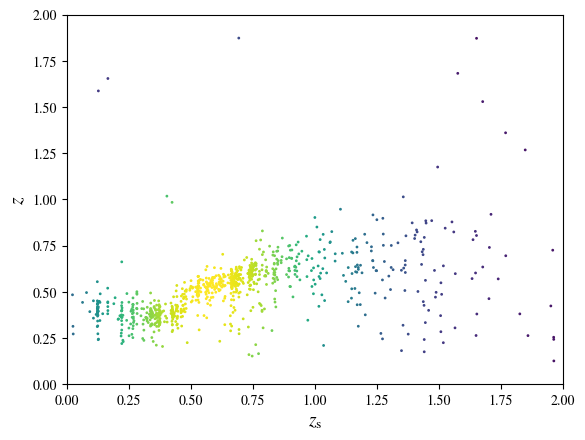

In [174]:
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([ztrue[:,0],zmean])
zd = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
plt.scatter(ztrue[:,0], zmean,c=zd, s=1)
plt.xlim(0,2)
plt.ylim(0,2)

plt.xlabel(r'$z_{\rm s}$', fontsize = 14)
plt.ylabel('$z$', fontsize = 14)

In [148]:
nmad(rerrz)

0.05350374693936794

In [149]:
sigma68(rerrz)

0.06909074627010126